# Module 3: Inverse Planning

In [1]:
using Gen
using Luxor
using Gadfly

## The Problem

Imaging we are observing an agent interact with the environment.
In this simple world, the agent can move towards an object if he likes it.

However, there may be obstacles in the way, making the journey more costly. 
> Denoted as `light_present`

In [2]:
struct Scene 
    object::Symbol
    light_present::Bool
end

If agent's preference for the object is **greater** than the cost associated with the obstacle (if present),
the agent will move towards the object.



Below, we are simply implementing a rendering function we will use to visualize different scenes.

In [3]:

function draw_scene(scene::Scene, moved::Bool,
                    is_obj_present = true)
    Drawing(700, 350, "scene_.png")
    origin()
    background("antiquewhite2")
    

    sethue("dodgerblue4")
    setline(8)
    fontsize(50)
    box_dim = 200
    box(0,0,box_dim,box_dim, :stroke)
    box(-box_dim,0,box_dim,box_dim, :stroke)
    box(box_dim,0,box_dim,box_dim, :stroke)
    
    robot = readpng("images/joyous_robot.png")
    placeimage(robot, -box_dim, 0; centered=true)

    if scene.light_present
        sethue("palevioletred")
        p1 = Point(-50,-50)
        p2 = Point(50,50)
        line(p1, p2, :stroke)
        p1 = Point(50,-50)
        p2 = Point(-50,50)
        line(p1, p2, :stroke)
    end
    
    if is_obj_present
        if scene.object == :square
            sethue("firebrick")
            box(box_dim,0,100,100, :fill)
        elseif scene.object == :triangle
            sethue("blue")
            p = Point(box_dim,0)
            ngon(p, 80, 3, :fill)
        else
            sethue("darkolivegreen3")
            p = Point(box_dim,0)
            Luxor.circle(p,50, :fill)
        end
    end
    
    if moved
        setdash("longdashed")
        sethue("grey28")
        startpoint = Point(-box_dim, -120)
        endpoint = Point(box_dim, -120)
        c1 = Point(-100,-150)
        c2 = Point(100,-150)
        arrow(startpoint,  c1, c2, endpoint;
                linewidth=8,
                arrowheadlength = 30,
                arrowheadangle = pi/8)
    end
    
    finish()
    preview()
end;

function draw_blank()
    Drawing(700, 350, "scene.png")
    background("antiquewhite2")
    finish()
    preview()
end;


Here is a scene where the agent **moved** toward `:square` and an obstacle **was not** present.

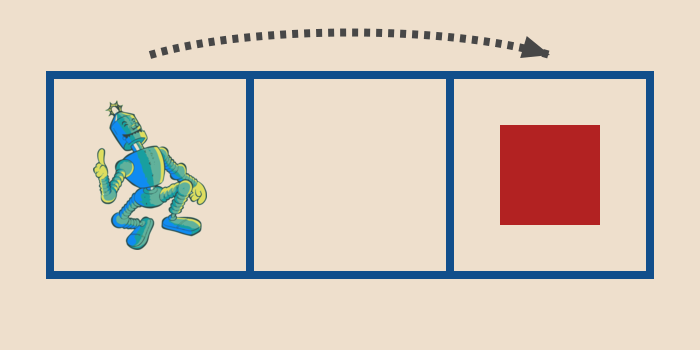

In [4]:
scene_1 = Scene(:square, 0)
draw_scene(scene_1, true)

Here the agent **does not** move towards the `:square` and an obstacle **is** present

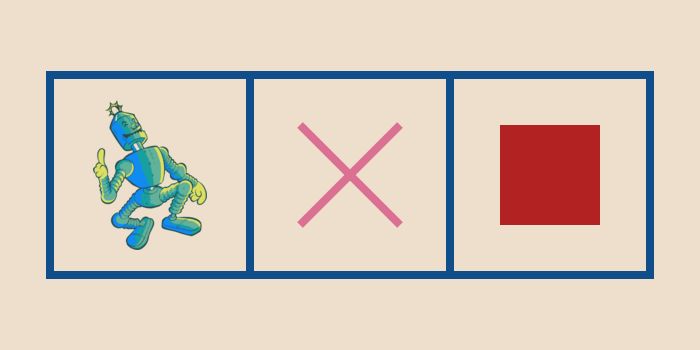

In [5]:
scene_2 = Scene(:square, true)
draw_scene(scene_2, false)

How much do you think the agent likes the `:square` given that we know the obstacle is costly?

\begin{align*}
P(square | S_1, S_2, M_1, M_2, C)
\end{align*}

Where:

- $square$ is the agent's preference for the square
- $S_1, S_2$ is the `scene` data for the two scenes (which object is present, whether the obstacle is present)
- $M_1, M_2$ are the observations, whether the agent moved for scene $i$
- $C$ is the known cost of the obstacle (not inferred)

## Inference - The generative model

The generative model below describes

1. The prior over prefernce for objects
2. The prior over cost for the obstacle
3. some *small* noise over observation (`99%` of the time the agent will move according to its planner)

In [6]:
@gen function generative_model(scenes::Vector{Scene})
    
    square = @trace(uniform_discrete(0, 2), (:object, :square))
    circle = @trace(uniform_discrete(0, 2), (:object, :circle))
    obstacle = @trace(uniform(-2, 0), :obstacle)
    n_scenes = size(scenes, 1)
    moved = Vector{Bool}(undef, n_scenes)
    for i = 1:n_scenes
        scene = scenes[i]
        # initially lets have a naive prior
        reward = scene.object == :square ? square : circle
        # Lets also assume the agent knows the cost
        cost = scene.light_present ? obstacle : 0

        # The planner is simple: move if reward > cost
        # for inference lets add some noise
        value = Int(reward + cost > 0)
        noise = 0.01
        # move 99% of the time in the proper direction
        prob = value * (1 - noise) + (1 - value)*(noise)
        moved[i] = @trace(bernoulli(prob), (:moved, i))
    end
    
    return moved
end;


Below, we define the righthand side of the posterior.

In [7]:
# The scenes
scenes = [scene_1, scene_2];
# Whether the agent moved
moved = [true, false];
obs = Gen.choicemap();
# The cost of the obstacle
obs[:obstacle] = -1.0
for i=1:size(scenes, 1)
    obs[(:moved, i)] = moved[i]
end

Here, we implement a simple Metropolis-Hasting procedure that computes our posterior

In [8]:
function mh_inference(model, args, obs, iter)
    objects = [(:object, s.object) for s in first(args)]
    (trace, _) = Gen.generate(model, args, obs)
    traces = Array{typeof(trace)}(undef, iter)
    traces[1] = trace
    for i = 2:iter
        # We will be doing inference over the perference of objects
        (traces[i], _) = mh(traces[i-1], select(objects...))
    end
    return traces
end;

In [9]:
traces = [last(mh_inference(generative_model, (scenes,), obs, 500)) for _=1:1000];
traces = vcat(traces...)
belief_square = Vector{Float64}(undef, size(traces, 1))

for i = 1:size(belief_square,1)
    belief_square[i] = traces[i][(:object, :square)]
end

# the average belief of ends of each chain
println(sum(belief_square) / size(traces, 1))

0.994


Now lets visualize the posterior (as a histogram) over the agent's preference for `:square` given the two scenes.

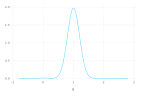

In [10]:
plot(x = belief_square, 
    Geom.density(bandwidth = 0.2))
 

How different would the belief of `:square` look if we only had the first scene?

\begin{align*}
P(square | S_1, M_1, C)
\end{align*}

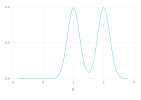

In [11]:
# The scenes
scenes = [scene_1];
# Whether the agent moved
moved = [true];
obs = Gen.choicemap();
# The cost of the obstacle
obs[:obstacle] = -1.0
for i=1:size(scenes, 1)
    obs[(:moved, i)] = moved[i]
end

traces = [last(mh_inference(generative_model, (scenes,), obs, 500)) for _=1:1000];
traces = vcat(traces...)
belief_square = Vector{Float64}(undef, size(traces, 1))

for i = 1:size(belief_square,1)
    belief_square[i] = traces[i][(:object, :square)]
end

plot(x = belief_square, 
    Geom.density(bandwidth = 0.2))


What if we didn't know the cost of the obstacle?

\begin{align*}
P(square, C | S_1, S_2, M_1, M_2)
\end{align*}

In [12]:
function mh_inference_2(model, args, obs, iter)
    objects = [(:object, s.object) for s in first(args)]
    (trace, _) = Gen.generate(model, args, obs)
    traces = Array{typeof(trace)}(undef, iter)
    traces[1] = trace
    for i = 2:iter
        # We will be doing inference over the perference of objects +
        # infernece of cost of the obstacle
        (traces[i], _) = mh(traces[i-1], select(objects..., :obstacle))
    end
    return traces
end;

In [13]:
# The scenes
scenes = [scene_1, scene_2];
# Whether the agent moved
moved = [true, false];
obs = Gen.choicemap();
# Note that we are not constraining on the cost of the obstacle
for i=1:size(scenes, 1)
    obs[(:moved, i)] = moved[i]
end

traces = [last(mh_inference_2(generative_model, (scenes,), obs, 500)) for _=1:1000];
traces = vcat(traces...)
belief_square = Vector{Float64}(undef, size(traces, 1))
belief_obstacle = Vector{Float64}(undef, size(traces, 1))

for i = 1:size(belief_square,1)
    belief_square[i] = traces[i][(:object, :square)]
    belief_obstacle[i] = traces[i][:obstacle]
end

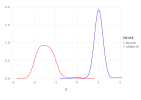

In [14]:
plot(Coord.cartesian(xmin=-3, xmax=2),
    layer(x = belief_square, Geom.density(bandwidth = 0.2),
        Theme(default_color="blue")),
    layer(x = belief_obstacle, Geom.density(bandwidth = 0.2),
        Theme(default_color="red")),
    Theme(alphas = [0.3, 0.3]),
    Guide.manual_color_key("latent",["square","obstacle"],
        ["blue","red"]))

What if we observed the agent interacting with a second object, `:circle`?

\begin{align*}
P(square, circle, C | S_1, S_2, S_3, M_1, M_2, M_3)
\end{align*}

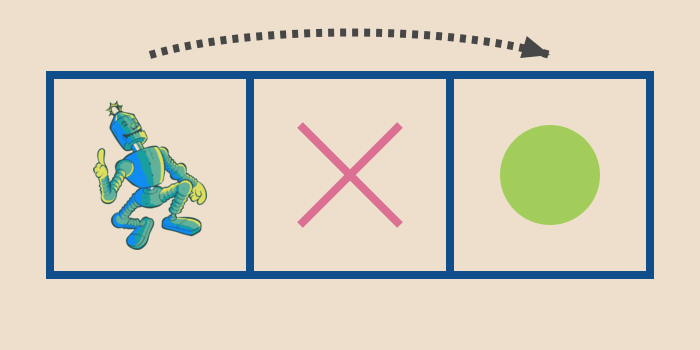

In [15]:
# The scenes
scene_3 = Scene(:circle, true);
scenes = [scene_1, scene_2, scene_3];
# Whether the agent moved
moved = [true, false, true];
obs = Gen.choicemap();
# Note that we are not constraining on the cost of the obstacle
for i=1:size(scenes, 1)
    obs[(:moved, i)] = moved[i]
end

draw_scene(scene_3, true)



In [16]:
traces = [last(mh_inference_2(generative_model, (scenes,), obs, 500)) for _=1:1000];
traces = vcat(traces...)
belief_square = Vector{Float64}(undef, size(traces, 1))
belief_obstacle = Vector{Float64}(undef, size(traces, 1))
belief_circle = Vector{Float64}(undef, size(traces, 1))

for i = 1:size(belief_square,1)
    belief_square[i] = traces[i][(:object, :square)]
    belief_circle[i] = traces[i][(:object, :circle)]
    belief_obstacle[i] = traces[i][:obstacle]
end



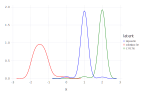

In [17]:
plot(Coord.cartesian(xmin=-3, xmax=3),
    layer(x = belief_square, Geom.density(bandwidth = 0.2),
        Theme(default_color="blue")),
    layer(x = belief_obstacle, Geom.density(bandwidth = 0.2),
        Theme(default_color="red")),
    layer(x = belief_circle, Geom.density(bandwidth = 0.2),
        Theme(default_color="green")),
    Theme(alphas = [0.3, 0.3]),
    Guide.manual_color_key("latent",["square","obstacle", "circle"],
        ["blue","red", "green"]))

## Sequential Inference

\begin{align*}
P(square, circle, C | S_1, S_2, S_3, M_1, M_2, M_3) \\
= P(circle | C, S_3, M_3)*P(square, C | S_1, S_2, M_1, M_2)
\end{align*}

In [111]:
@gen function sequential_gm(scene::Scene, t::Int)
    square = @trace(uniform_discrete(0, 2), (:object, :square))
    circle = @trace(uniform_discrete(0, 2), (:object, :circle))
    obstacle = @trace(uniform(-2, 0), :obstacle)
    # initially lets have a naive prior
    reward = (scene.object == :square) ? square : circle
    # Lets also assume the agent knows the cost
    cost = scene.light_present ? obstacle : 0

    # The planner is simple: move if reward > cost
    # for inference lets add some noise
    value = Int(reward + cost > 0)
    noise = 0.01
    # move 99% of the time in the proper direction
    prob = value * (1 - noise) + (1 - value)*(noise)
    moved = @trace(bernoulli(prob), (:moved, t))
    return moved
end;

In [112]:
function resim_step_1(trace)
    (trace, _) = mh(trace, select(:obstacle, :square))
    return trace
end;
function resim_step_2(trace)
    (trace, _) = mh(trace, select(:circle))
    return trace
end;

function extract_estimates!(record, trace)
    choices = Gen.get_choices(trace)
    record[1] = choices[(:object, :square)]
    record[2] = choices[:obstacle]
    record[3] = choices[(:object, :circle)]
end;

In [113]:
function smc_inference(model, args, obs, steps, n)
    # initialize particles on the first scene
    nt = size(obs, 1)
    state = Gen.initialize_particle_filter(model, (args[1], 1), obs[1], n)
    states = Vector{typeof(state)}(undef, nt)
    states[1] = deepcopy(state)
    for t = 2:nt
        perturbation_move = steps[t-1]
        for i=1:n
            state.traces[i] = perturbation_move(state.traces[i])
        end
        
        Gen.maybe_resample!(state, ess_threshold=n/2)
        Gen.particle_filter_step!(state, (args[t],t), 
            (UnknownChange(),), obs[t])
        
        states[t] = deepcopy(state)
    end
    
    perturbation_move = last(steps)
    for i=1:n
        state.traces[i] = perturbation_move(state.traces[i])
    end
    
    return states
end;

In [122]:
# The scenes
scene_3 = Scene(:circle, true);
scenes = [scene_1, scene_2, scene_3];
# Whether the agent moved
moved = [true, false, true];
seq_obs = Array{Any}(undef, 3)
# Note that we are not constraining on the cost of the obstacle
for i=1:size(scenes, 1)
    o = Gen.choicemap()
    o[(:moved, i)] = moved[i]
    seq_obs[i] = o
end
steps = [resim_step_1, resim_step_1, resim_step_2]
n_particles = 1000
states = smc_inference(sequential_gm, scenes, seq_obs,
    steps, n_particles);
final_state = last(states)

belief_square = Matrix{Float64}(undef, size(scenes,1), n_particles)
belief_obstacle = Matrix{Float64}(undef, size(scenes,1), n_particles)
belief_circle = Matrix{Float64}(undef, size(scenes,1), n_particles)

for i = 1:size(scenes,1)
    state = states[i]
    traces = sample_unweighted_traces(state, n_particles)
    for j = 1:n_particles
        belief_square[i, j] = traces[j][(:object, :square)]
        belief_circle[i, j] = traces[j][(:object, :circle)]
        belief_obstacle[i, j] = traces[j][:obstacle]
        
    end
end

1.037
1.12
1.958
│
├── :obstacle : -1.2192351579053202
│
├── (:object, :circle) : 2
│
├── (:moved, 3) : true
│
└── (:object, :square) : 1



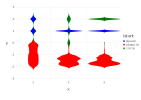

In [125]:

#println(belief_square)
xs = repeat([1,2,3], n_particles)


plot(
    layer(x = xs,y = belief_square,
        Geom.violin(), Theme(default_color="blue", alphas = [0.2])),
    layer(x = xs,y = belief_obstacle,
        Geom.violin(), Theme(default_color="red", alphas = [0.2])),
    layer(x = xs,y = belief_circle,
        Geom.violin(), Theme(default_color="green", alphas = [0.2])),
    Guide.manual_color_key("latent",["square","obstacle", "circle"],
        ["blue","red", "green"]))

